In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from dataloader import prep_dataloader
from experiments.utils import init_Seed

init_Seed(0)
device = 'cuda'

def onehot(label, classes):
    onehot = torch.zeros(1, classes, device=device)
    onehot.scatter_(1, torch.tensor([[label]]).to(device), 1)
    return onehot

def cross_entropy_onehot(pred, target):
    return (- target * F.log_softmax(pred, dim=-1)).sum().to(device)

In [2]:
dateset = 'mnist'
train_data, valid_data, train_loader, valid_loader, channel, size, classes = prep_dataloader(dateset)

C:\ProgramData\Miniconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


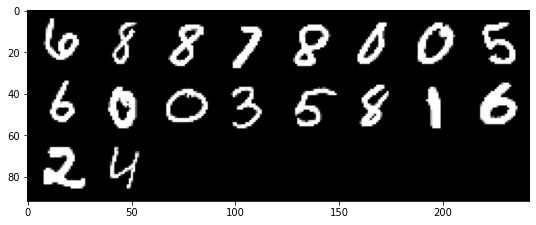

In [3]:
images, _ = next(iter(train_loader))
grid = make_grid(images, )
plt.figure(figsize=(9, 9))
plt.imshow(grid.permute(1, 2, 0))

In [4]:
class LeNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=10, img_size=28):
      super(LeNet, self).__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_channels, 12, kernel_size=5, padding=5//2, stride=2),
          nn.Sigmoid(),
          nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
          nn.Sigmoid(),
          nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
          nn.Sigmoid(),
      )
      x_dummy = torch.randn(1, in_channels, img_size, img_size)
      # print((self.body(x_dummy)).shape)
      out_size = torch.prod( torch.tensor((self.conv(x_dummy)).shape))
      # print(out_size)
      self.linear = nn.Sequential(
          nn.Linear(out_size, out_channels)
      )
      for layer in self.conv:
        if type(layer) != nn.Sigmoid:
          nn.init.uniform_(layer.weight, a=-0.5 , b=0.5)
          nn.init.uniform_(layer.bias, a=-0.5 , b=0.5)
      for layer in self.linear:
        nn.init.uniform_(layer.weight, a=-0.5 , b=0.5)
        nn.init.uniform_(layer.bias, a=-0.5 , b=0.5)

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.shape[0], -1)
    x = self.linear(x)
    return x

In [5]:
conv1 = nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2)

nn.init.uniform_(conv1.weight, a=-0.5 , b=0.5)
nn.init.uniform_(conv1.bias, a=-0.5 , b=0.5)

passport_gamma = torch.randn((1, 1, 28, 28), device='cuda')
passport_beta = torch.randn((1, 1, 28, 28), device='cuda')

encoder = nn.Sequential(nn.Flatten(), 
                                nn.Linear(12 * 14 * 14, 10), 
                                # nn.Linear(128, 6 * 28 * 28)
                                ).cuda()

class LeNet2(nn.Module):
  def __init__(self, in_channels=3, out_channels=10, img_size=28):
      super(LeNet2, self).__init__()


  
      
      self.conv2 = nn.Sequential(
          nn.Sigmoid(),
          nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
          nn.Sigmoid(),
          nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
          nn.Sigmoid(),
      )
      x_dummy = torch.randn(1, in_channels, img_size, img_size)
      # print((self.body(x_dummy)).shape)
      # out_size = torch.prod( torch.tensor((self.conv2(self.conv1(x_dummy))).shape))
      out_size = torch.prod( torch.tensor((self.conv2(conv1(x_dummy))).shape))
      # print(out_size)
      self.linear = nn.Sequential(
          nn.Linear(out_size, out_channels)
      )
      # for layer in self.conv1:
      #   if type(layer) != nn.Sigmoid:
      #     nn.init.uniform_(layer.weight, a=-0.5 , b=0.5)
      #     nn.init.uniform_(layer.bias, a=-0.5 , b=0.5)
      for layer in self.conv2:
        if type(layer) != nn.Sigmoid:
          nn.init.uniform_(layer.weight, a=-0.5 , b=0.5)
          nn.init.uniform_(layer.bias, a=-0.5 , b=0.5)
      for layer in self.linear:
        nn.init.uniform_(layer.weight, a=-0.5 , b=0.5)
        nn.init.uniform_(layer.bias, a=-0.5 , b=0.5)

  def forward(self, x):
    # x = self.conv1(x)
    x = conv1(x)
    # print(conv1(passport_gamma).shape)
    gamma = encoder(conv1(passport_gamma)).mean()
    beta = encoder(conv1(passport_beta)).mean()

    # gamma = 1. + (gamma - 1) * 0.01
    # beta /= 100

    x.mul_(gamma).add_(beta)

    x = self.conv2(x)
    x = x.view(x.shape[0], -1)
    x = self.linear(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 28, 28])


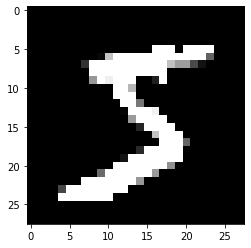

In [6]:
# img, label = train_data[400]
img, label = train_data[0]

# plt.imshow(img[0])
grid = make_grid([img])
plt.imshow(grid.cpu().detach().permute(1, 2, 0))
print(img.shape)


In [7]:
model = LeNet2(channel, classes, size).cuda()
conv1.cuda()
output = model(img.unsqueeze(dim=0).cuda())

In [8]:
a = torch.tensor([1., 2.], requires_grad=True)
b = torch.tensor([2., 4.], requires_grad=True)
c = (a + b).sum()   
torch.autograd.grad(c, [a, b])

(tensor([1., 1.]), tensor([1., 1.]))

In [9]:
# model.conv1.parameters().data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 28, 28])

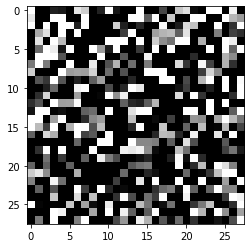

In [10]:

# loss_fn = nn.CrossEntropyLoss()
# loss = loss_fn(output, torch.tensor([label]).cuda())

label_onehot = onehot(label, classes)
loss = cross_entropy_onehot(output, label_onehot)


target_grad =  [g.detach().clone() for g in torch.autograd.grad(loss, model.parameters())]
# target_grad =  [g.detach().clone() for g in torch.autograd.grad(loss, model.conv1.parameters()), 
    # list(model.conv2.parameters()), 
    # list(model.linear.parameters())
    # ])]

img_shape = (1, channel, size, size)
dummy_input = torch.randn(img_shape, device='cuda', requires_grad=True)
# dummy_output = torch.randn(1, device='cuda', requires_grad=True)
dummy_output = torch.randn(classes, device='cuda', requires_grad=True)

# plt.imshow(.detach().cpu().numpy())

grid = make_grid([dummy_input[0]])
plt.imshow(grid.cpu().detach().permute(1, 2, 0))
dummy_output.shape
dummy_input.shape

In [11]:
optimizer = opt.LBFGS([dummy_input, dummy_output], lr=0.1)

In [12]:
def train(model, target_grad, dummy_input, dummy_target, optimizer, epochs, plot=True, img=None):
    # move the model to the device
    model.train()
    # training loop
    iterations = []
    stack_list = []
    for epoch in range(epochs):
      def closure():
          optimizer.zero_grad()

          # doutput = model(torch.tanh(dummy_input).cuda())
          doutput = model(dummy_input.cuda())

          # loss_fn = nn.CrossEntropyLoss()
          # loss = loss_fn(doutput, torch.tensor([5]).cuda())

          target = F.softmax(dummy_target, dim=-1).to(device)
          loss = cross_entropy_onehot(doutput, target)


          dummy_grad = torch.autograd.grad(loss, model.parameters(), create_graph=True) # dummy gradient
          # compute the MSE between the true and dummy grad
          square_loss = 0
          for dg, tg in zip(dummy_grad, target_grad):
            square_loss += ((dg - tg).pow(2).sum())
          square_loss.backward()
          return square_loss

      optimizer.step(closure)
      
      if plot:
          if (epoch) % 50 == 0:
            stack_list.append(torch.clone(dummy_input[0].cpu()))
            stack = torch.stack(list(reversed(list(reversed(stack_list)) + [img])))
            print(len(stack))
            print(f"Epoch {epoch+1}, loss: {closure()}")
            iterations.append(epoch)
            # if dummy_input.cpu().shape[0] == 1:
            grid = make_grid(stack, nrow=len(stack), )
            plt.imshow(grid.cpu().detach().permute(1, 2, 0))
            # print(dummy_input.min())
            # else:
              # plt.imshow(dummy_input.cpu().detach().permute(1, 2, 0))
              # print(dummy_input)
            plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
Epoch 1, loss: 105.32382202148438


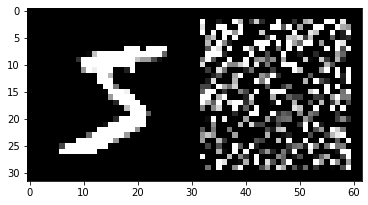

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
Epoch 51, loss: 1.7684980946341966e-07


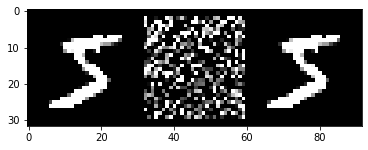

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
Epoch 101, loss: 1.7684980946341966e-07


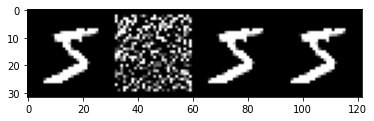

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
Epoch 151, loss: 1.7684980946341966e-07


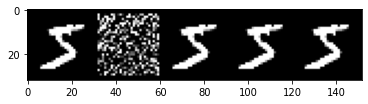

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
Epoch 201, loss: 1.7684980946341966e-07


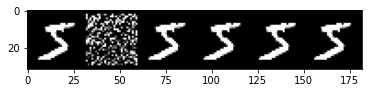

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
Epoch 251, loss: 1.7684980946341966e-07


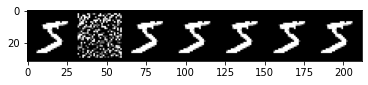

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8
Epoch 301, loss: 1.7684980946341966e-07


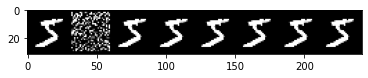

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9
Epoch 351, loss: 1.7684980946341966e-07


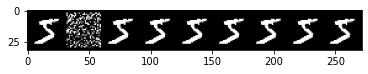

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10
Epoch 401, loss: 1.7684980946341966e-07


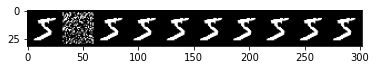

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11
Epoch 451, loss: 1.7684980946341966e-07


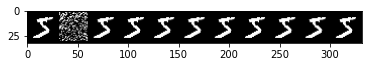

In [13]:
train(model, target_grad, dummy_input, dummy_output, optimizer, 500, img=img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


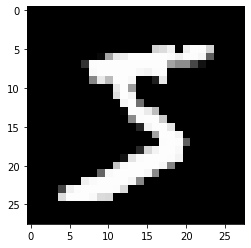

In [14]:
grid = make_grid([torch.tanh(dummy_input[0])])
plt.imshow(grid.cpu().detach().permute(1, 2, 0))

In [15]:
dummy_output.argmax()

tensor(5, device='cuda:0')

In [16]:
label

5